In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42

In [ ]:
features_dataset = pd.read_csv('/content/drive/MyDrive/ML/archive/data/Training_set_values.csv', index_col="id")
test_dataset = pd.read_csv('/content/drive/MyDrive/ML/archive/data/Test_set_values.csv', index_col="id")
labels_dataset = pd.read_csv('/content/drive/MyDrive/ML/archive/data/Training_set_labels.csv', index_col="id")

In [ ]:
X = features_dataset
test = test_dataset
y = labels_dataset

In [ ]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
X.shape

(59400, 39)

class distribution

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64


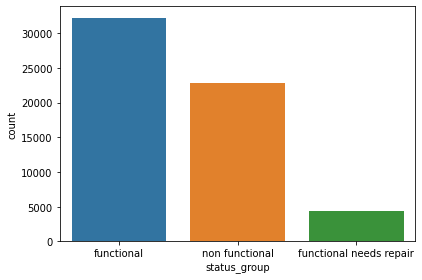

In [ ]:
print(y['status_group'].value_counts(normalize=True))
sns.countplot(x='status_group', data=y)
plt.tight_layout()


Null values and duplicates

In [ ]:
print('\nNull Values in Training \n{}'.format(X.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_dataset.isnull().sum()))
print('\nNull Values in Labels \n{}'.format(y.isnull().sum()))


print('\nDuplicated values in train {}'.format(X.duplicated().sum()))
print('Duplicated values in test {}'.format(test_dataset.duplicated().sum()))



Null Values in Training 
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group

In [ ]:
X.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [ ]:
joined_train = X.join(y)

remove duplicates in train data

In [ ]:
#Drop duplicates
def drop_duplicates(df):
  df.drop_duplicates(subset=df.columns, keep="first", inplace=True)

drop_duplicates(joined_train)
print('Duplicated values in train {}'.format(joined_train.duplicated().sum()))


Duplicated values in train 0


In [ ]:
X = joined_train.iloc[:,:-1]

In [ ]:
X.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
X.shape

(59364, 39)

#Missing value imputation

* ```funder```-replace by 'other'.
* ```installer```-replace by 'other'.
* ```subvillage``` - using mode of subvillages grouped by region_code wise.
* ```public_meeting``` - using median.
* ```scheme managment``` - using mode of scheme_managment grouped by region wise.
* ```scheme name``` - using mode of scheme_name grouped by region wise.
* ```permit``` - using median.


In [ ]:
funder_l = list(map(str,X["funder"].unique()))
funder_l.sort()
print(funder_l)

In [ ]:
X['funder'].replace(to_replace=('0', 'nan', None), value='other', inplace=True)

In [ ]:
installer_l = list(map(str,X["installer"].unique()))
installer_l.sort()
print(installer_l)

In [ ]:
X['installer'].replace(to_replace=('0', 'nan', '-', None), value='other', inplace=True)

In [ ]:
subvillage_region_code = X.groupby(['region_code'])['subvillage'].agg(pd.Series.mode)
scheme_name_region_code = X.groupby(['region'])['scheme_name'].agg(pd.Series.mode)
scheme_management_region_code = X.groupby(['region'])['scheme_management'].agg(pd.Series.mode)

In [ ]:
def impute_mode(df,map_df,col,grouped_col):
  df.loc[df[col].isnull(),[col]] = df[df[col].isnull()].apply(
      lambda row: map_df.loc[row[grouped_col]][0],axis=1
  )

In [ ]:
impute_mode(X,subvillage_region_code,'subvillage','region_code')
impute_mode(X,scheme_name_region_code,'scheme_name','region')
impute_mode(X,scheme_management_region_code,'scheme_management','region')


In [ ]:
public_meeting_median = X['public_meeting'].median()
permit_median = X['permit'].median()

In [ ]:
X.loc[X['public_meeting'].isnull(), 'public_meeting'] = public_meeting_median
X.loc[X['permit'].isnull(), 'permit'] = permit_median

In [ ]:
def impute_nan(df):
  df['funder'].replace(to_replace=('0', 'nan', None), value='other', inplace=True)
  df['installer'].replace(to_replace=('0', 'nan', '-', None), value='other', inplace=True)

  subvillage_region_code = df.groupby(['region_code'])['subvillage'].agg(pd.Series.mode)
  scheme_name_region_code = df.groupby(['region'])['scheme_name'].agg(pd.Series.mode)
  scheme_management_region_code = df.groupby(['region'])['scheme_management'].agg(pd.Series.mode)

  impute_mode(df,subvillage_region_code,'subvillage','region_code')
  impute_mode(df,scheme_name_region_code,'scheme_name','region')
  impute_mode(df,scheme_management_region_code,'scheme_management','region')

  public_meeting_median = df['public_meeting'].median()
  permit_median = df['permit'].median()

  df.loc[df['public_meeting'].isnull(), 'public_meeting'] = public_meeting_median
  df.loc[df['permit'].isnull(), 'permit'] = permit_median



In [ ]:
subvillage_region_code_t = test.groupby(['region_code'])['subvillage'].agg(pd.Series.mode)
scheme_name_region_code_t = test.groupby(['region'])['scheme_name'].agg(pd.Series.mode)
scheme_management_region_code_t = test.groupby(['region'])['scheme_management'].agg(pd.Series.mode)

In [ ]:
impute_nan(test)

In [ ]:
print('\nNull Values in Training \n{}'.format(X.isnull().sum()))
print('\nNull Values in Training \n{}'.format(test.isnull().sum()))



Null Values in Training 
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
so

#longitude and latitudes

(0,0) logitude, latitude values were replaced by the median (logitude,latitude) of the respective region_code

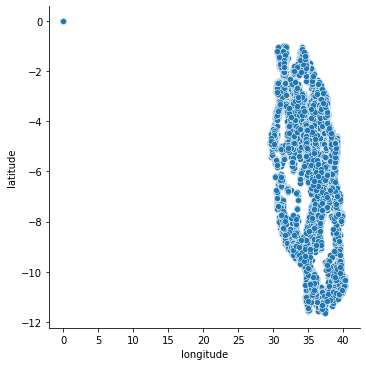

In [ ]:
sns.relplot(
    x="longitude", y="latitude", data=X
);

In [ ]:
X_geo = X.groupby(['region_code'])[['latitude', 'longitude']].median()

In [ ]:
 X.loc[X['longitude'] == 0,['latitude', 'longitude']] = X[X['longitude']==0].apply(
     lambda row: X_geo.loc[row['region_code'],['latitude', 'longitude']],axis=1
)[['latitude', 'longitude']]

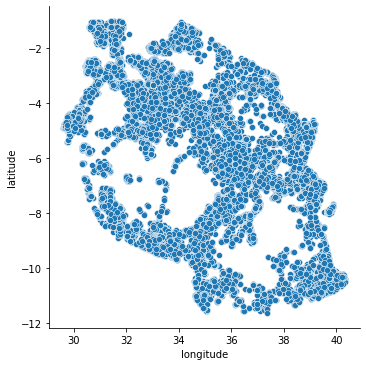

In [ ]:
sns.relplot(
    x="longitude", y="latitude", data=X
);

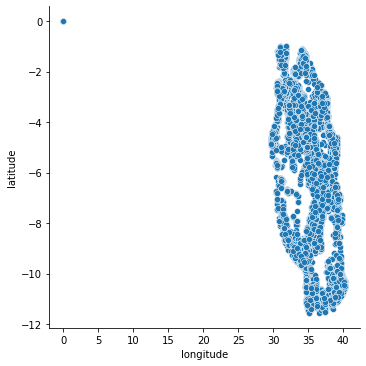

In [ ]:
sns.relplot(
    x="longitude", y="latitude", data=test
);

In [ ]:
test_geo = test.groupby(['region_code'])[['latitude', 'longitude']].median()

In [ ]:
 test.loc[test['longitude'] == 0,['latitude', 'longitude']] = test[test['longitude']==0].apply(
     lambda row: test_geo.loc[row['region_code'],['latitude', 'longitude']],axis=1
)[['latitude', 'longitude']]

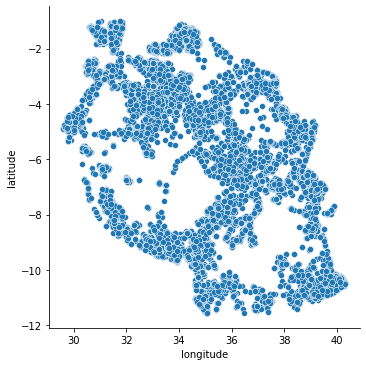

In [ ]:
sns.relplot(
    x="longitude", y="latitude", data=test
);

#Clustering 

A new feature ```Cluster``` was created by clustering longitudes and latitude based on ```population```.

In [ ]:
# clusturing of long and lattitude\
from sklearn.cluster import KMeans
import seaborn as sns

X_l = X.loc[:, ["population", "latitude", "longitude"]]
kmeans = KMeans(n_clusters=8, random_state=RANDOM_SEED)
X_l["Cluster"] = kmeans.fit_predict(X_l)
X_l["Cluster"] = X_l["Cluster"].astype("category")

X_l.head()

,population,latitude,longitude,Cluster
id,,,,
69572,109,-9.856322,34.938093,0
8776,280,-2.147466,34.698766,2
34310,250,-3.821329,37.460664,2
67743,58,-11.155298,38.486161,0
19728,0,-1.825359,31.130847,0


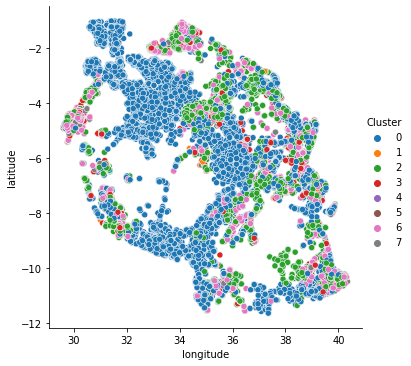

In [ ]:
sns.relplot(
    x="longitude", y="latitude", hue="Cluster", data=X_l
);

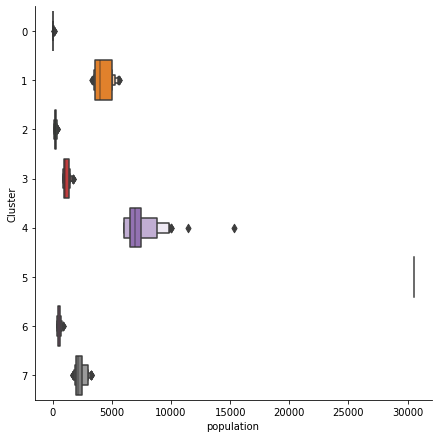

In [ ]:
X_l["population"]  = X["population"] 
sns.catplot(x="population", y="Cluster", data=X_l , kind="boxen", height=6);

In [ ]:
X["Cluster"] = X_l["Cluster"].astype("object")

In [ ]:
X_test_l = test.loc[:, ["population", "latitude", "longitude"]]
kmeans = KMeans(n_clusters=8, random_state=RANDOM_SEED)
X_test_l["Cluster"] = kmeans.fit_predict(X_test_l)
X_test_l["Cluster"] = X_test_l["Cluster"].astype("category")

X_test_l.head()

,population,latitude,longitude,Cluster
id,,,,
50785,321,-4.059696,35.290799,3
51630,300,-3.309214,36.656709,3
17168,500,-5.004344,34.767863,7
45559,250,-9.418672,38.058046,3
49871,60,-10.950412,35.006123,0


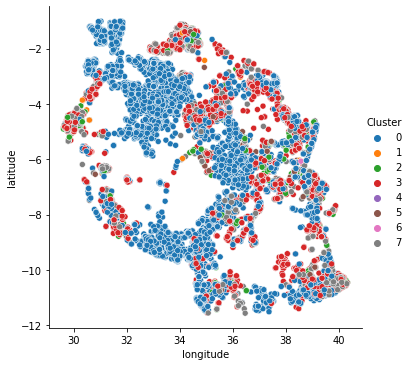

In [ ]:
sns.relplot(
    x="longitude", y="latitude", hue="Cluster", data=X_test_l
);

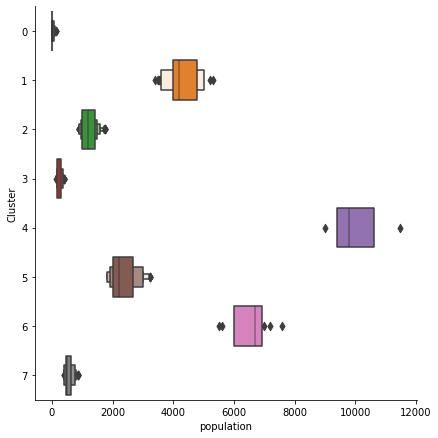

In [ ]:
X_test_l["population"]  = X_test_l["population"] 
sns.catplot(x="population", y="Cluster", data=X_test_l , kind="boxen", height=6);

In [ ]:
test["Cluster"] = X_test_l["Cluster"].astype("object")

In [ ]:
test.shape

(14850, 40)

In [ ]:
len(X.columns)

40

In [ ]:
y = joined_train["status_group"]

In [ ]:
y.shape

(59364,)

In [ ]:
X.shape

(59364, 40)

In [ ]:
joined_processed_train = X.join(y)

In [ ]:
joined_processed_train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Cluster,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,1,GeoData Consultants Ltd,Other,M,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,B,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,V,K,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,functional


In [ ]:
categorical_cols = ['funder', 'installer','wpt_name', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']

int_cols = ["gps_height","num_private","population","construction_year"]

float_cols = ["amount_tsh","longitude","latitude"]

cols = categorical_cols+int_cols+float_cols+["date_recorded"]

In [ ]:
cat_cols = categorical_cols +["status_group"]

In [ ]:
joined_processed_train_cat = joined_processed_train.loc[:,cat_cols]

#Building-Up featuers

```date recorded``` columns was seperated into 2 featuers, ```year``` and ```month```

In [ ]:
joined_processed_train['date_recorded'] = pd.to_datetime(joined_processed_train['date_recorded'])
joined_processed_train['year'] = joined_processed_train['date_recorded'].dt.year
joined_processed_train['month'] = joined_processed_train['date_recorded'].dt.month
joined_processed_train.drop(columns = 'date_recorded', inplace = True)

In [ ]:
test['date_recorded'] = pd.to_datetime(test['date_recorded'])
test['year'] = test['date_recorded'].dt.year
test['month'] = test['date_recorded'].dt.month
test.drop(columns = 'date_recorded', inplace = True)

In [ ]:
joined_processed_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,Cluster,status_group,year,month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,functional,2011,3
8776,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,1,GeoData Consultants Ltd,Other,M,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2,functional,2013,3
34310,25.0,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2,functional,2013,2
67743,0.0,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,B,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0,non functional,2013,1
19728,0.0,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,V,K,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,functional,2011,7


In [ ]:
print(joined_processed_train.shape)
print(test.shape)

(59364, 42)
(14850, 41)


#Pipeline

steps in the pipline:
1. Convert all categorical columns to string
2. OneHot encoded all the categorical columns
3. All the numerical columns were scaled using standard scalar
4. Trained the pipeline using OneVsRest Classifier with XGBoostClassifier



In [ ]:
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    FunctionTransformer)
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
joined_processed_train.dtypes

amount_tsh               float64
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_quality             object
quality_gr

In [ ]:
num_cols = int_cols+float_cols+['year','month']
cat_cols_selected = list(set(joined_processed_train.columns)-set(num_cols)-set(['status_group']))

In [ ]:
l1 = list(set(joined_processed_train.columns)-set(['status_group'])).sort()
l2 = list(set(cat_cols_selected+num_cols)).sort()
l1 == l2

True

In [ ]:
len(cat_cols_selected)+len(num_cols), joined_processed_train.shape

(41, (59364, 42))

In [ ]:
def convert_categorical_to_string(data):
    return pd.DataFrame(data).astype(str)

CategoricalTypeConverter = FunctionTransformer(
    convert_categorical_to_string
)

In [ ]:
categorical_pipeline = Pipeline(
    steps=[
        (
            'typeConverter', 
            CategoricalTypeConverter
        ),
        (
            'standardizer', 
            OneHotEncoder(
                handle_unknown='ignore',
                dtype=float
            )
        )
    ]
)

In [ ]:
numerical_pipeline = Pipeline(
    steps=[
        (
            'standardizer', 
            StandardScaler()
        )
    ]
)

In [ ]:
 preprocessor = ColumnTransformer(
        transformers=[
            (
                'numericalPreprocessor', 
                numerical_pipeline, 
                num_cols
            ),
            (
                'categoricalPreprocessor', 
                categorical_pipeline, 
                cat_cols_selected
            )
        ]
    )

In [ ]:
pipeline = Pipeline(
    steps=[
        (
            'preprocessor', 
            preprocessor
        ),
        (
            'classifier', 
            OneVsRestClassifier(
                estimator=XGBClassifier(max_depth = 20, n_estimators =  250)
            )
        )
    ]
)

In [ ]:
X_selected = joined_processed_train.drop(columns=["status_group"])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, random_state = RANDOM_SEED, test_size=0.1,  stratify=y)

In [ ]:
pipeline.fit(
    X_train, 
    y_train
)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numericalPreprocessor',
                                                  Pipeline(memory=None,
                                                           steps=[('standardizer',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['gps_height', 'num_private',
                                                   'population',
                    

In [ ]:
pred = pipeline.predict(X_test)

In [ ]:
from sklearn import metrics

print("Accuracy: {}".format(metrics.accuracy_score(y_test, pred)))

Accuracy: 0.8228061310426141


In [ ]:
pipeline.fit(X_selected,y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numericalPreprocessor',
                                                  Pipeline(memory=None,
                                                           steps=[('standardizer',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['gps_height', 'num_private',
                                                   'population',
                    

#Create submission file

In [ ]:
X_validate = test
y_validate = pipeline.predict(
    X_validate
)
df_predictions = pd.DataFrame(
    y_validate, 
    index=X_validate.index, 
    columns=['status_group']
)
df_predictions.to_csv(
    '/content/drive/MyDrive/ML/archive/data/submissions/submission7.csv'
)